# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import warnings
import random
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, GRU
import itertools
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")

# Data Loading And Preprocessing

In [ ]:
# Try to load the dataset from the local file, If not possible, then defaults to google drive version
def getfile(location_pair,**kwargs):
    (loc,gdrive)=location_pair
    try:
        out=pd.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out = pd.read_csv(loc,**kwargs)
    return out

fname=("Local_Area_Unemployment_Statistics__LAUS_.csv","https://drive.google.com/file/d/1xoDHEKiN-y4QyZNET8SdlVRSsgW_7TLy/view?usp=sharing")
raw_data=getfile(fname)
raw_data.head()

local file not found; accessing Google Drive


,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate
0,State,California,01/01/1976,1976,January,N,Final,9672362,8668016,1004346,0.104
1,State,California,01/01/1976,1976,January,Y,Final,9774280,8875685,898595,0.092
2,County,Los Angeles County,01/01/1976,1976,January,N,Final,3364151,3040058,324093,0.096
3,County,Los Angeles County,01/01/1976,1976,January,Y,Final,3381856,3081806,300050,0.089
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,01/01/1976,1976,January,N,Final,3364151,3040058,324093,0.096


In [ ]:
raw_data['Date']= pd.to_datetime(raw_data['Date'])
raw_data['ts'] = raw_data.Date.values.astype(np.int64) # convert datetime to pandas timestamps
raw_data['Employment Rate']=raw_data['Employment ']/raw_data['Labor Force']
raw_data.head()

,Area Type,Area Name,Date,Year,Month,Seasonally Adjusted (Y/N),Status (Preliminary / Final),Labor Force,Employment,Unemployment,Unemployment Rate,ts,Employment Rate
0,State,California,1976-01-01,1976,January,N,Final,9672362,8668016,1004346,0.104,189302400000000000,0.896163
1,State,California,1976-01-01,1976,January,Y,Final,9774280,8875685,898595,0.092,189302400000000000,0.908065
2,County,Los Angeles County,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.096,189302400000000000,0.903663
3,County,Los Angeles County,1976-01-01,1976,January,Y,Final,3381856,3081806,300050,0.089,189302400000000000,0.911277
4,Metropolitan Area,Los Angeles-Long Beach-Glendale MD,1976-01-01,1976,January,N,Final,3364151,3040058,324093,0.096,189302400000000000,0.903663


In [ ]:
#Loading the necessary columns
raw_data.columns = ['Area Type', 'Area Name', 'Date', 'Year', 'Month',
       'Seasonally Adjusted (Y/N)', 'Status (Preliminary / Final)',
       'Labor Force', 'Employment', 'Unemployment', 'Unemployment Rate','ts','Employment Rate']
subData_State = raw_data.loc[(raw_data['Area Type']=='State')]

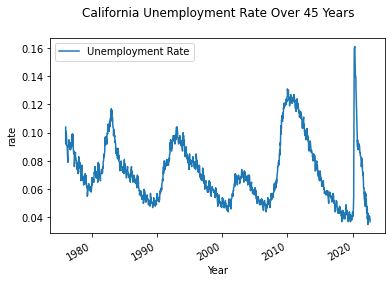

In [ ]:
# Checking a plot of unemployment rate over the years

graphPlotter = subData_State[['Date','Unemployment Rate']]
graphPlotter.set_index(["Date"], inplace=True)
graphPlotter.plot(title="California Unemployment Rate Over 45 Years\n", ylabel="rate", xlabel="Year")

In [ ]:
subData_State.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122 entries, 0 to 178345
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Area Type                     1122 non-null   object        
 1   Area Name                     1122 non-null   object        
 2   Date                          1122 non-null   datetime64[ns]
 3   Year                          1122 non-null   int64         
 4   Month                         1122 non-null   object        
 5   Seasonally Adjusted (Y/N)     1122 non-null   object        
 6   Status (Preliminary / Final)  1122 non-null   object        
 7   Labor Force                   1122 non-null   int64         
 8   Employment                    1122 non-null   int64         
 9   Unemployment                  1122 non-null   int64         
 10  Unemployment Rate             1122 non-null   float64       
 11  ts                          

In [ ]:
graphPlotter.head()

,Unemployment Rate
Date,
1976-01-01,0.104
1976-01-01,0.092
1977-01-01,0.099
1977-01-01,0.092
1978-01-01,0.083


Need comments here for upcoming cells

In [ ]:
model_data = graphPlotter.reset_index()['Unemployment Rate']
model_data.head()

0    0.104
1    0.092
2    0.099
3    0.092
4    0.083
Name: Unemployment Rate, dtype: float64

In [ ]:
# using sklearn MinMaxScaler for normalizing thr data
scaler=MinMaxScaler(feature_range=(0,1))
model_data_normalized=scaler.fit_transform(np.array(model_data).reshape(-1,1))
model_data_normalized

array([[0.54761905],
       [0.45238095],
       [0.50793651],
       ...,
       [0.45238095],
       [0.1031746 ],
       [0.18253968]])

In [ ]:
training_size=int(len(model_data_normalized)*0.65)
test_size=len(model_data_normalized)-training_size
train_data,test_data=model_data_normalized[0:training_size,:],model_data_normalized[training_size:len(model_data_normalized),:1]
print(training_size,test_size)

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape, y_train.shape)
print(X_test.shape, ytest.shape)

array([[0.66666667, 0.56349206, 0.53968254, ..., 0.4047619 , 0.42063492,
        0.28571429],
       [0.56349206, 0.53968254, 0.43650794, ..., 0.42063492, 0.28571429,
        0.3015873 ],
       [0.53968254, 0.43650794, 0.42857143, ..., 0.28571429, 0.3015873 ,
        0.17460317],
       ...,
       [0.12698413, 0.15079365, 0.06349206, ..., 0.06349206, 0.03174603,
        0.04761905],
       [0.15079365, 0.06349206, 0.07936508, ..., 0.03174603, 0.04761905,
        0.43650794],
       [0.06349206, 0.07936508, 0.03174603, ..., 0.04761905, 0.43650794,
        0.45238095]])

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#Traing Model using LSTM

In [ ]:
#First model
model = Sequential()
model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error')

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=20,batch_size=32,verbose=1)

Epoch 1/20
40/40 [==============================] - 9s 102ms/step - loss: 0.0413 - val_loss: 0.0491
Epoch 2/20
40/40 [==============================] - 3s 78ms/step - loss: 0.0281 - val_loss: 0.0476
Epoch 3/20
40/40 [==============================] - 3s 79ms/step - loss: 0.0239 - val_loss: 0.0547
Epoch 4/20
40/40 [==============================] - 3s 77ms/step - loss: 0.0218 - val_loss: 0.1153
Epoch 5/20
40/40 [==============================] - 4s 94ms/step - loss: 0.0214 - val_loss: 0.0788
Epoch 6/20
40/40 [==============================] - 4s 87ms/step - loss: 0.0201 - val_loss: 0.0662
Epoch 7/20
40/40 [==============================] - 3s 78ms/step - loss: 0.0186 - val_loss: 0.0744
Epoch 8/20
40/40 [==============================] - 3s 80ms/step - loss: 0.0183 - val_loss: 0.0663
Epoch 9/20
40/40 [==============================] - 3s 80ms/step - loss: 0.0171 - val_loss: 0.0941
Epoch 10/20
40/40 [==============================] - 3s 78ms/step - loss: 0.0165 - val_loss: 0.1071
Epoch 11

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

10/10 [==============================] - 0s 19ms/step


In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
ytest = scaler.inverse_transform(np.array(ytest).reshape(-1,1))

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.2872032571206362

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.030729401237103725

# Hyper-Parameter Tuning with mini batch training 


## Using Adam optimizer

In [ ]:

def LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, ytest):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        model = Sequential()
        model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout))

        if first_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if second_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if third_additional_layer:
            model.add(GRU(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        model.add(LSTM(units=n_neurons, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(units=1, activation='linear'))

        
        model.compile( 'Adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        model_checkpoint = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        model.fit(X_train, y_train, validation_split=0.3, epochs=16, batch_size=n_batch_size, callbacks=[early_stopping, model_checkpoint], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        test_accuracy = model.evaluate(X_test, ytest, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [ ]:
config = [[True], [False], [False], [16, 32], [4, 8, 16], [0.2]]

#['RMSprop', 'Adam', 'Adagrad']

#list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, ytest)  # change x_train shape

[(True, False, False, 16, 4, 0.2), (True, False, False, 16, 8, 0.2), (True, False, False, 16, 16, 0.2), (True, False, False, 32, 4, 0.2), (True, False, False, 32, 8, 0.2), (True, False, False, 32, 16, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.03481, saving model to best_model.h5

Epoch 2: val_loss did not improve from 0.03481

Epoch 3: val_loss improved from 0.03481 to 0.02822, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.02822

Epoch 5: val_loss improved from 0.02822 to 0.02689, saving model to best_model.h5

Epoch 6: val_loss did not improve from 0.02689

Epoch 7: val_loss improved from 0.02689 to 0.02664, saving model to best_model.h5

Epoch 8: val_loss improved from 0.02664 to 0.02567, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.02567

Epoch 10: val_loss improved from 0.02567 to 0.02528, saving model to best_model.h5

Epoch 11: val_l

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
4,True,False,False,32,8,0.2,"[0.016759539023041725, 0.12945863604545593]","[0.06900686025619507, 0.26269155740737915]"
2,True,False,False,16,16,0.2,"[0.024115998297929764, 0.155293270945549]","[0.07213375717401505, 0.2685772776603699]"
1,True,False,False,16,8,0.2,"[0.01944561116397381, 0.13944752514362335]","[0.08029636740684509, 0.2833661437034607]"
0,True,False,False,16,4,0.2,"[0.01934737153351307, 0.13909482955932617]","[0.08124330639839172, 0.28503212332725525]"
3,True,False,False,32,4,0.2,"[0.014585006050765514, 0.12076839804649353]","[0.08620065450668335, 0.2935994863510132]"
5,True,False,False,32,16,0.2,"[0.022155551239848137, 0.14884741604328156]","[0.09681986272335052, 0.3111588954925537]"


In [ ]:
results = model.evaluate(X_test, ytest)

10/10 [==============================] - 0s 27ms/step - loss: 0.0595


In [ ]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set RMSE: {np.round(results, 4)}\n')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)}\n')
print(f'{np.round((results - hist.iloc[0, -1][1])*100/np.round(results, 4))}% Improvement')

Best Combination: 
 first_additional_layer = True
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 8
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0595

Results After Tunning:
 Test Set RMSE: [0.069  0.2627]

-342.0% Improvement


## Using Adagrad optimizer


In [ ]:
def LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, ytest):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        model = Sequential()
        model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout))

        if first_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if second_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if third_additional_layer:
            model.add(GRU(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        model.add(LSTM(units=n_neurons, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(units=1, activation='linear'))

        
        model.compile( 'Adagrad', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        model_checkpoint = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        model.fit(X_train, y_train, validation_split=0.3, epochs=16, batch_size=n_batch_size, callbacks=[early_stopping, model_checkpoint], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        test_accuracy = model.evaluate(X_test, ytest, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [ ]:
config = [[True], [False], [False], [16, 32], [4, 8, 16], [0.2]]

#['RMSprop', 'Adam', 'Adagrad']

#list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, ytest)  # change x_train shape

[(True, False, False, 16, 4, 0.2), (True, False, False, 16, 8, 0.2), (True, False, False, 16, 16, 0.2), (True, False, False, 32, 4, 0.2), (True, False, False, 32, 8, 0.2), (True, False, False, 32, 16, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.07685, saving model to best_model.h5

Epoch 2: val_loss improved from 0.07685 to 0.05785, saving model to best_model.h5

Epoch 3: val_loss improved from 0.05785 to 0.04765, saving model to best_model.h5

Epoch 4: val_loss improved from 0.04765 to 0.04188, saving model to best_model.h5

Epoch 5: val_loss improved from 0.04188 to 0.03879, saving model to best_model.h5

Epoch 6: val_loss improved from 0.03879 to 0.03695, saving model to best_model.h5

Epoch 7: val_loss improved from 0.03695 to 0.03598, saving model to best_model.h5

Epoch 8: val_loss improved from 0.03598 to 0.03552, saving model to best_model.h5

Epoch 9: val_loss improved from 0.03552 to

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
2,True,False,False,16,16,0.2,"[0.032532524317502975, 0.18036775290966034]","[0.058281343430280685, 0.24141529202461243]"
0,True,False,False,16,4,0.2,"[0.03249090164899826, 0.1802523285150528]","[0.06077728420495987, 0.24653048813343048]"
1,True,False,False,16,8,0.2,"[0.03256300836801529, 0.18045222759246826]","[0.062003906816244125, 0.24900583922863007]"
4,True,False,False,32,8,0.2,"[0.03255950286984444, 0.18044252693653107]","[0.06303238123655319, 0.2510625123977661]"
5,True,False,False,32,16,0.2,"[0.03282087296247482, 0.18116532266139984]","[0.06349162757396698, 0.2519754469394684]"
3,True,False,False,32,4,0.2,"[0.030952170491218567, 0.17593228816986084]","[0.0646989494562149, 0.2543598711490631]"


In [ ]:
results = model.evaluate(X_test, ytest)

10/10 [==============================] - 0s 20ms/step - loss: 0.0943


In [ ]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)}\n')

Best Combination: 
 first_additional_layer = True
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 16
 n_batch_size = 16
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0943

Results After Tunning:
 Test Set RMSE: [0.0583 0.2414]

-156.0% Improvement


## Using RMSprop optimizer

In [ ]:

def LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, ytest):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        model = Sequential()
        model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout))

        if first_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if second_additional_layer:
            model.add(LSTM(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        if third_additional_layer:
            model.add(GRU(units=n_neurons, return_sequences=True))
            model.add(Dropout(dropout))

        model.add(LSTM(units=n_neurons, return_sequences=False))
        model.add(Dropout(dropout))
        model.add(Dense(units=1, activation='linear'))

        
        model.compile( 'RMSprop', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        model_checkpoint = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        model.fit(X_train, y_train, validation_split=0.3, epochs=16, batch_size=n_batch_size, callbacks=[early_stop, model_checkpoint], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        test_accuracy = model.evaluate(X_test, ytest, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [ ]:
config = [[True], [False], [False], [16, 32], [4, 8, 16], [0.2]]

#['RMSprop', 'Adam', 'Adagrad']

#list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, ytest)  # change x_train shape

[(True, False, False, 16, 4, 0.2), (True, False, False, 16, 8, 0.2), (True, False, False, 16, 16, 0.2), (True, False, False, 32, 4, 0.2), (True, False, False, 32, 8, 0.2), (True, False, False, 32, 16, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.03567, saving model to best_model.h5

Epoch 2: val_loss improved from 0.03567 to 0.03306, saving model to best_model.h5

Epoch 3: val_loss improved from 0.03306 to 0.02879, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.02879

Epoch 5: val_loss improved from 0.02879 to 0.02837, saving model to best_model.h5

Epoch 6: val_loss did not improve from 0.02837

Epoch 7: val_loss improved from 0.02837 to 0.02619, saving model to best_model.h5

Epoch 8: val_loss did not improve from 0.02619

Epoch 9: val_loss did not improve from 0.02619

Epoch 10: val_loss improved from 0.02619 to 0.02493, saving model to best_model.h5

Epoch 11: val_l

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
5,True,False,False,32,16,0.2,"[0.022302171215415, 0.14933910965919495]","[0.054144151508808136, 0.23268896341323853]"
2,True,False,False,16,16,0.2,"[0.024121489375829697, 0.15531094372272491]","[0.07086361199617386, 0.2662022113800049]"
1,True,False,False,16,8,0.2,"[0.02024386264383793, 0.1422809213399887]","[0.07669618725776672, 0.2769407629966736]"
0,True,False,False,16,4,0.2,"[0.0193770881742239, 0.13920161128044128]","[0.08000601828098297, 0.282853364944458]"
4,True,False,False,32,8,0.2,"[0.017180608585476875, 0.13107481598854065]","[0.08215011656284332, 0.2866184115409851]"
3,True,False,False,32,4,0.2,"[0.012626159004867077, 0.11236618459224701]","[0.093537338078022, 0.3058387339115143]"


In [ ]:
results = model.evaluate(X_test, ytest)

10/10 [==============================] - 0s 20ms/step - loss: 0.0943


In [ ]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results After Tunning:\n Test Set RMSE: {np.round(hist.iloc[0, -1], 4)}\n')

Best Combination: 
 first_additional_layer = True
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 32
 n_batch_size = 16
 dropout = 0.2
**************************
Results Before Tunning:
 Test Set RMSE: 0.0943

Results After Tunning:
 Test Set RMSE: [0.0541 0.2327]

-147.0% Improvement


#Final Model

The Final Model:  https://colab.research.google.com/drive/14Fq49KLq_1NmmDqKbqaYsdfRpmGLd-PD#scrollTo=aDhIjMHrngxn

